In [2]:
# import libraries 
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, average_precision_score
import time
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)

In [3]:
# load the dataset
data = pd.read_csv("cardio_train.csv")


In [4]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# EDA
# Univariate analysis
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,20207.403759,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,34999.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,52499.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,69999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


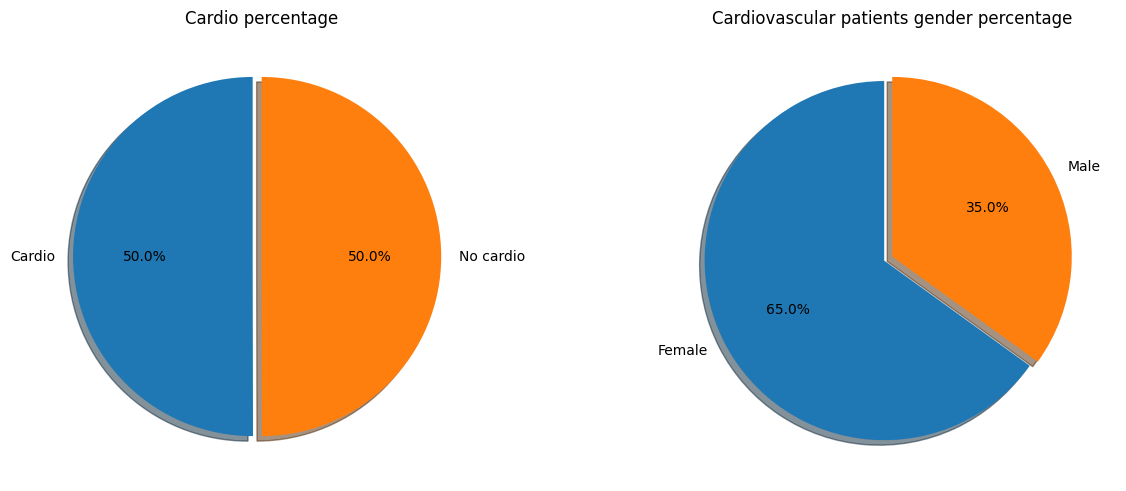

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14,20))
plt.tight_layout(pad=10)
ax[0].pie(x=data['cardio'].value_counts(), labels=['Cardio', 'No cardio'],autopct='%1.1f%%', shadow=True, startangle=90, explode=(0.05,0.0))
ax[0].title.set_text('Cardio percentage')
ax[1].pie(x=data['gender'].value_counts(), labels=['Female', 'Male'],autopct='%1.1f%%', shadow=True, startangle=90, explode=(0.05,0.0))
ax[1].title.set_text('Cardiovascular patients gender percentage')

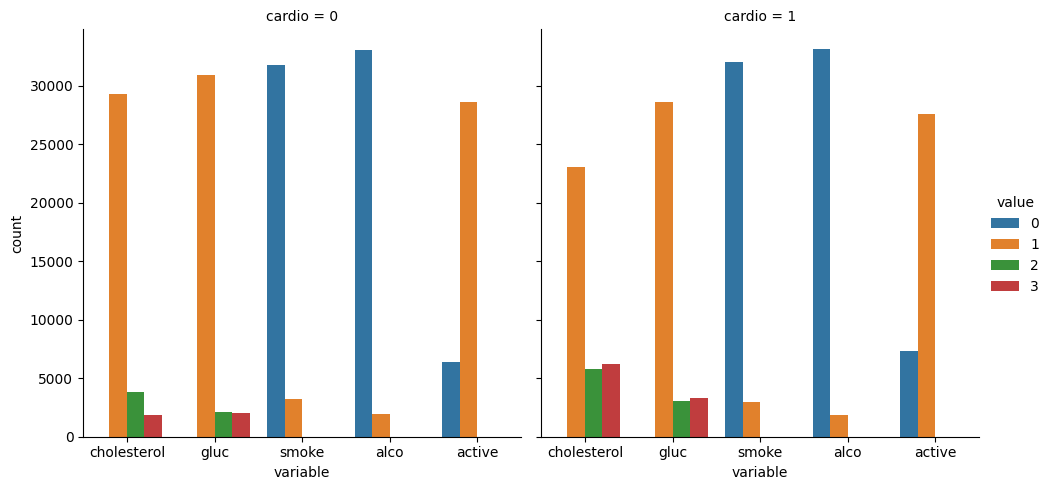

In [8]:
# Bivariate analysis
df_long = pd.melt(data, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");

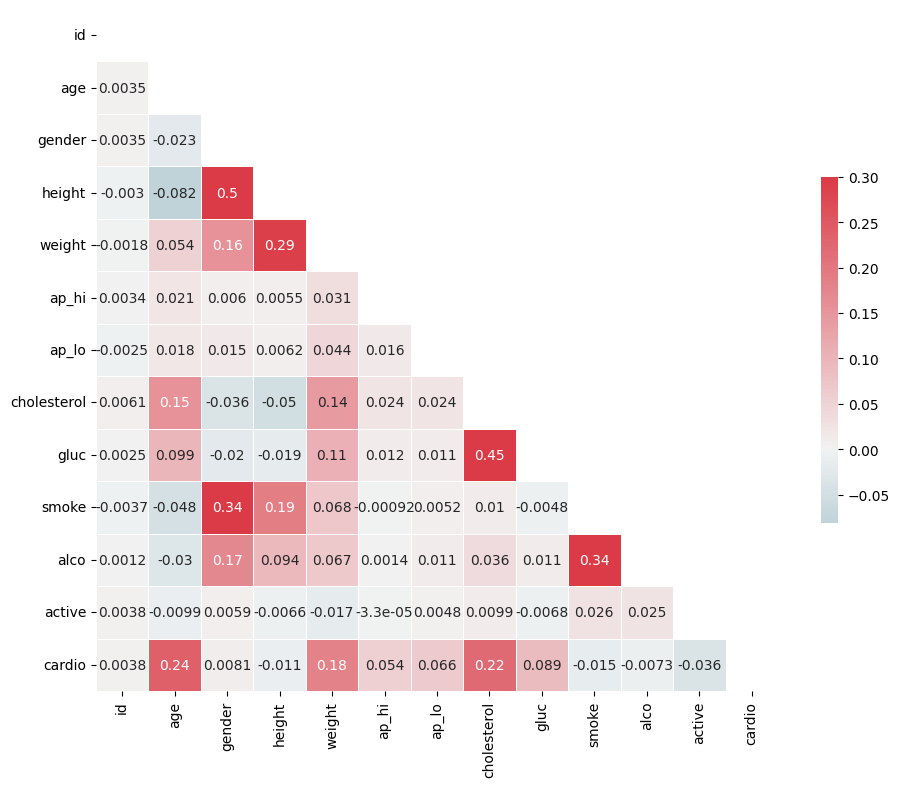

In [9]:
# Multivariate analysis

# correation heatmap matrix
corr = data.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
# check if any NA or missing value
data.isnull().values.any()

False

In [ ]:
# remove outliers
data = data[(data['height']<250) & (data['weight']>20.0)]
data = data[(data['ap_hi']<300) & (data['ap_lo']<300)]
data = data[(data['ap_hi']>0) & (data['ap_lo']>0)]

# remove id column
data = data.drop(columns=["id"])
# drop rows with any missing data
data = data.dropna(axis=0, how='any')
# separate features and target variable
X = data.drop(columns=["cardio"])
y = data["cardio"]
X.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0
5,21914,1,151,67.0,120,80,2,2,0,0,0
6,22113,1,157,93.0,130,80,3,1,0,0,1
7,22584,2,178,95.0,130,90,3,3,0,0,1
8,17668,1,158,71.0,110,70,1,1,0,0,1
9,19834,1,164,68.0,110,60,1,1,0,0,0


In [ ]:
def myTrainTestSplit(xData, yData):
  Xtrain, Xtest, ytrain, ytest = train_test_split(xData, yData, test_size=0.2, random_state=42)
  return Xtrain, Xtest, ytrain, ytest

Xtrain, Xtest, ytrain, ytest = myTrainTestSplit(X,y)

# standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Xtrain_std = scaler.fit_transform(Xtrain)
Xtest_std = scaler.transform(Xtest)

Time for PCA: 0.04
Time for LR: 0.13
Training Precision: 0.7506
Testing Accuracy: 0.7243
Recall score: 0.6734
R1 score: 0.6561


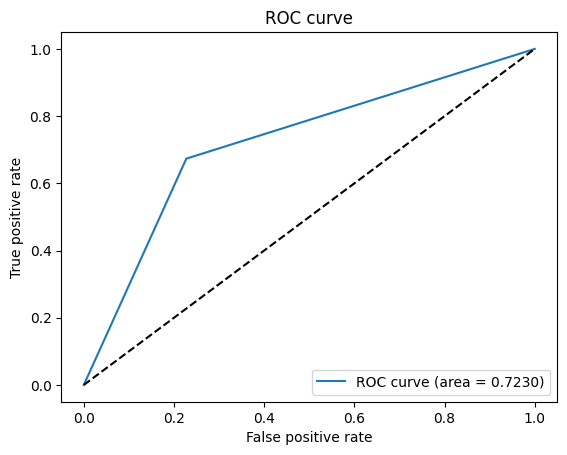

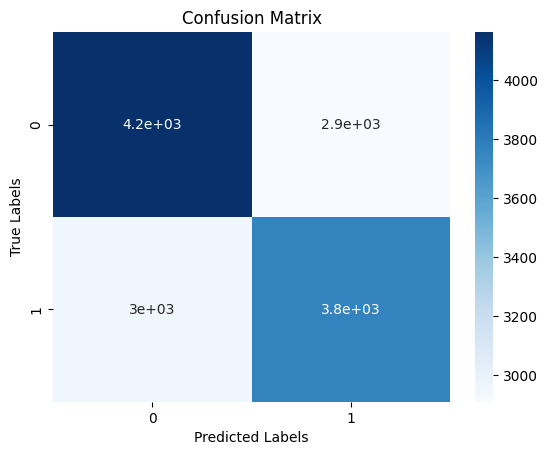

In [ ]:
# PCA on a logistic regression model
pca = PCA(n_components=11)

start_time = time.time()
Xtrain_pca = pca.fit_transform(Xtrain_std)
Xtest_pca = pca.transform(Xtest_std)
train_time = time.time() - start_time
print("Time for PCA: {:.2f}".format(train_time))

# train a logistic regression model on the transformed training data
start_time = time.time()
lr = LogisticRegression()
lr.fit(Xtrain_pca, ytrain)
train_time = time.time() - start_time
print("Time for LR: {:.2f}".format(train_time))

ytrain_pred = lr.predict(Xtrain_pca)
train_precision = precision_score(ytrain, ytrain_pred)
print("Training Precision: {:.4f}".format(train_precision))

ytest_pred = lr.predict(Xtest_pca)
test_accuracy = accuracy_score(ytest, ytest_pred)
print("Testing Accuracy: {:.4f}".format(test_accuracy))

recall = recall_score(ytest, ytest_pred)
print("Recall score: {:.4f}".format(recall))

r1_score = average_precision_score(ytest, ytest_pred)
print("R1 score: {:.4f}".format(r1_score))

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
auc = roc_auc_score(ytest, ytest_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# print the confusion matrix
ytest_pred = lr.predict(Xtest_std)
ytest_pred = ytest_pred >= ytest_pred.mean()
cm = confusion_matrix(ytest, ytest_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Neural Network
# define a neural network with multiple hidden layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(11,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# train the model on the training data
start_time = time.time()
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
model.fit(Xtrain_std, ytrain, epochs=100, batch_size=64, validation_split=0.2, callbacks=[earlystop])
print("Execution time: %s seconds" % (time.time() - start_time))

Epoch 1/100
690/690 [==============================] - 4s 4ms/step - loss: 0.6239 - accuracy: 0.6504 - val_loss: 0.5738 - val_accuracy: 0.7262
Epoch 2/100
690/690 [==============================] - 2s 3ms/step - loss: 0.6071 - accuracy: 0.6672 - val_loss: 0.5632 - val_accuracy: 0.7319
Epoch 3/100
690/690 [==============================] - 4s 5ms/step - loss: 0.6060 - accuracy: 0.6706 - val_loss: 0.5600 - val_accuracy: 0.7315
Epoch 4/100
690/690 [==============================] - 2s 4ms/step - loss: 0.6049 - accuracy: 0.6710 - val_loss: 0.5694 - val_accuracy: 0.7276
Epoch 5/100
690/690 [==============================] - 3s 4ms/step - loss: 0.6029 - accuracy: 0.6739 - val_loss: 0.5678 - val_accuracy: 0.7349
Epoch 6/100
690/690 [==============================] - 3s 4ms/step - loss: 0.6013 - accuracy: 0.6743 - val_loss: 0.5616 - val_accuracy: 0.7361
Epoch 6: early stopping
Execution time: 17.84006643295288 seconds


1725/1725 [==============================] - 3s 2ms/step
Training Precision: 0.7476
432/432 [==============================] - 1s 3ms/step
Testing Accuracy: 0.7267
Recall score: 0.6895
R1 score: 0.6572


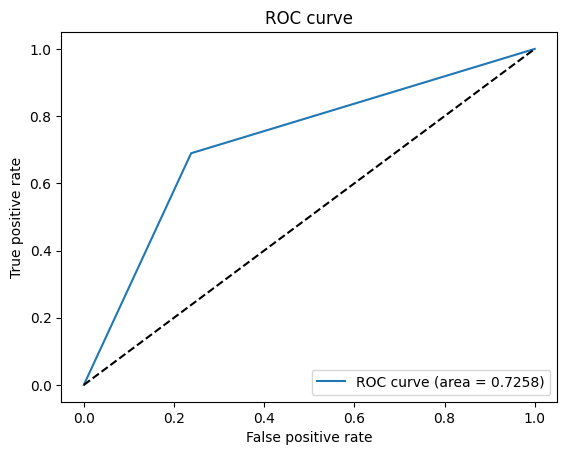

432/432 [==============================] - 1s 2ms/step


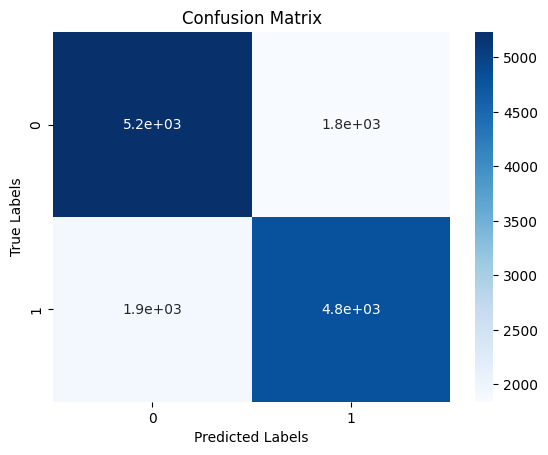

In [ ]:
ytrain_pred = model.predict(Xtrain_std)
ytrain_pred = np.round(ytrain_pred)
train_precision = precision_score(ytrain, ytrain_pred)
print("Training Precision: {:.4f}".format(train_precision))

ytest_pred = model.predict(Xtest_std)
ytest_pred = np.round(ytest_pred)
test_accuracy = accuracy_score(ytest, ytest_pred)
print("Testing Accuracy: {:.4f}".format(test_accuracy))

recall = recall_score(ytest, ytest_pred)
print("Recall score: {:.4f}".format(recall))

r1_score = average_precision_score(ytest, ytest_pred)
print("R1 score: {:.4f}".format(r1_score))

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
auc = roc_auc_score(ytest, ytest_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# print the confusion matrix
ytest_pred = model.predict(Xtest_std)
ytest_pred = ytest_pred >= ytest_pred.mean()
cm = confusion_matrix(ytest, ytest_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Time for DT: 0.34
Training Precision: 0.8046
Testing Accuracy: 0.6993
Recall score: 0.6686
R1 score: 0.6300


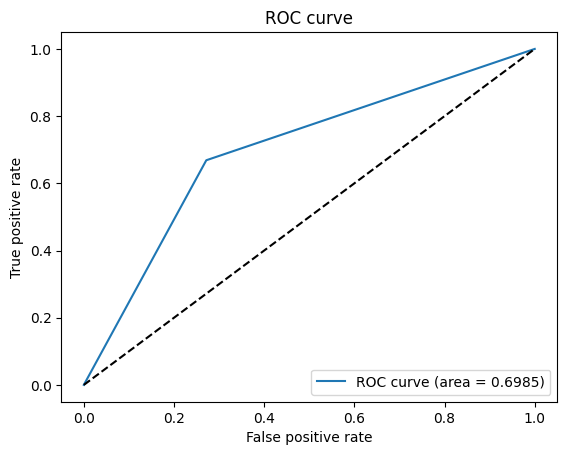

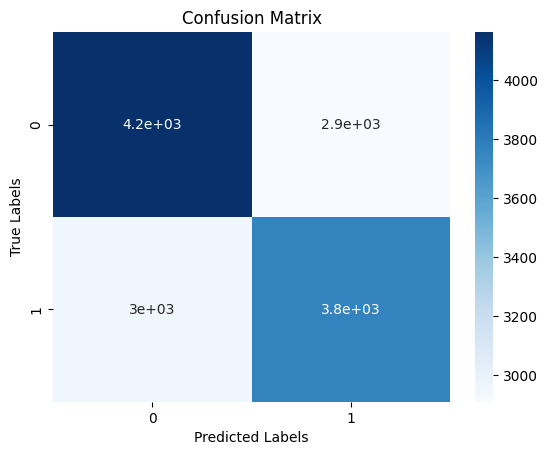

In [ ]:
# Decision Tree
start_time = time.time()
clf = DecisionTreeClassifier(max_depth=200, min_samples_split=50, random_state=42)
clf.fit(Xtrain, ytrain)
train_time = time.time() - start_time
print("Time for DT: {:.2f}".format(train_time))

# evaluate the model
ytrain_pred = clf.predict(Xtrain)
train_precision = precision_score(ytrain, ytrain_pred)
print("Training Precision: {:.4f}".format(train_precision))

ytest_pred = clf.predict(Xtest)
test_accuracy = accuracy_score(ytest, ytest_pred)
print("Testing Accuracy: {:.4f}".format(test_accuracy))

recall = recall_score(ytest, ytest_pred)
print("Recall score: {:.4f}".format(recall))

r1_score = average_precision_score(ytest, ytest_pred)
print("R1 score: {:.4f}".format(r1_score))

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
auc = roc_auc_score(ytest, ytest_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# print the confusion matrix
ytest_pred = lr.predict(Xtest_std)
ytest_pred = ytest_pred >= ytest_pred.mean()
cm = confusion_matrix(ytest, ytest_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Time for RF: 12.53
Training Precision: 0.9998
Testing Accuracy: 0.7170
Recall score: 0.6999
R1 score: 0.6459


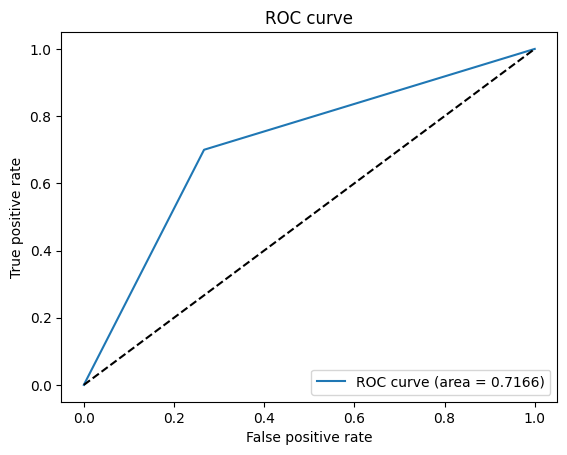

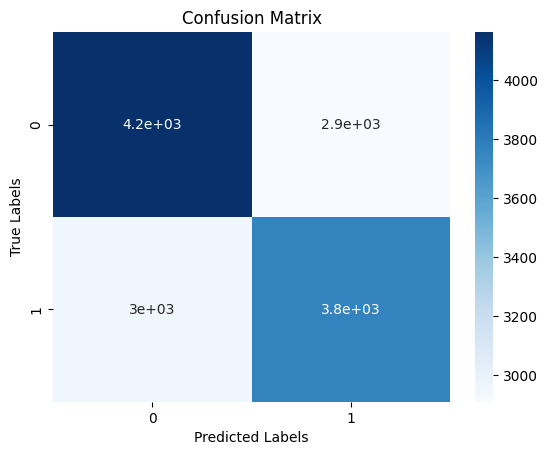

In [ ]:
# Random Forest
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xtrain_std, ytrain)
train_time = time.time() - start_time
print("Time for RF: {:.2f}".format(train_time))

# evaluate the model
ytrain_pred = rf.predict(Xtrain_std)
train_precision = precision_score(ytrain, ytrain_pred)
print("Training Precision: {:.4f}".format(train_precision))

ytest_pred = rf.predict(Xtest_std)
test_accuracy = accuracy_score(ytest, ytest_pred)
print("Testing Accuracy: {:.4f}".format(test_accuracy))

recall = recall_score(ytest, ytest_pred)
print("Recall score: {:.4f}".format(recall))

r1_score = average_precision_score(ytest, ytest_pred)
print("R1 score: {:.4f}".format(r1_score))

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
auc = roc_auc_score(ytest, ytest_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# print the confusion matrix
ytest_pred = lr.predict(Xtest_std)
ytest_pred = ytest_pred >= ytest_pred.mean()
cm = confusion_matrix(ytest, ytest_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Time for XGboost: 9.36
Training Precision: 0.7864
Testing Accuracy: 0.7344
Recall score: 0.6884
R1 score: 0.6659


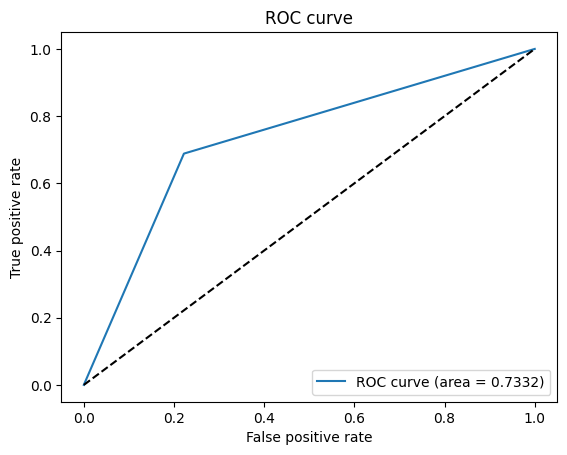

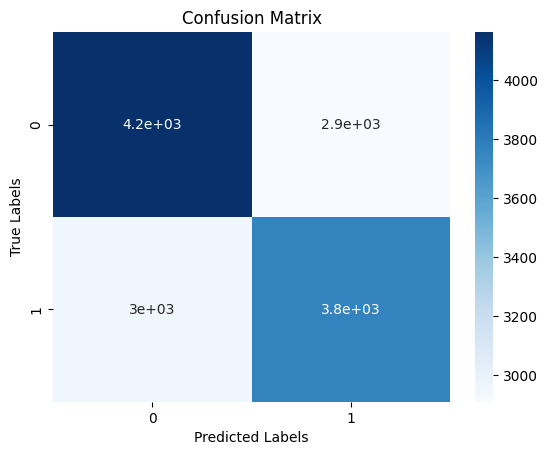

In [ ]:
# XGBoost
start_time = time.time()
xgb = XGBClassifier()
xgb.fit(Xtrain_std, ytrain)
train_time = time.time() - start_time
print("Time for XGboost: {:.2f}".format(train_time))

# evaluate the model
ytrain_pred = xgb.predict(Xtrain_std)
train_precision = precision_score(ytrain, ytrain_pred)
print("Training Precision: {:.4f}".format(train_precision))

ytest_pred = xgb.predict(Xtest_std)
test_accuracy = accuracy_score(ytest, ytest_pred)
print("Testing Accuracy: {:.4f}".format(test_accuracy))

recall = recall_score(ytest, ytest_pred)
print("Recall score: {:.4f}".format(recall))

r1_score = average_precision_score(ytest, ytest_pred)
print("R1 score: {:.4f}".format(r1_score))

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
auc = roc_auc_score(ytest, ytest_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# print the confusion matrix
ytest_pred = lr.predict(Xtest_std)
ytest_pred = ytest_pred >= ytest_pred.mean()
cm = confusion_matrix(ytest, ytest_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# KNN
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(Xtrain_std, ytrain)
train_time = time.time() - start_time
print("Time for KNN: {:.2f}".format(train_time))

# evaluate the model
ytrain_pred = knn.predict(Xtrain_std)
train_precision = precision_score(ytrain, ytrain_pred)
print("Training Precision: {:.4f}".format(train_precision))

ytest_pred = knn.predict(Xtest_std)
test_accuracy = accuracy_score(ytest, ytest_pred)
print("Testing Accuracy: {:.4f}".format(test_accuracy))

recall = recall_score(ytest, ytest_pred)
print("Recall score: {:.4f}".format(recall))

r1_score = average_precision_score(ytest, ytest_pred)
print("R1 score: {:.4f}".format(r1_score))

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
auc = roc_auc_score(ytest, ytest_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# print the confusion matrix
ytest_pred = lr.predict(Xtest_std)
ytest_pred = ytest_pred >= ytest_pred.mean()
cm = confusion_matrix(ytest, ytest_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Time for KNN: 0.11


In [ ]:
# SVM
binary_y_train = ytrain >= ytrain.mean()
binary_y_test = ytest >= ytest.mean()
start_time = time.time()
pipe = Pipeline([('scaler', StandardScaler()), ("svm", LinearSVC(max_iter=5000))])
pipe.fit(Xtrain, binary_y_train)
train_time = time.time() - start_time
print("Time for SVM: {:.2f}".format(train_time))


# evaluate the model
ytrain_pred = pipe.predict(Xtrain)
train_precision = precision_score(binary_y_train, pipe.predict(Xtrain))
print("Training Precision: {:.4f}".format(train_precision))

ytest_pred = pipe.predict(Xtest)
test_accuracy = accuracy_score(binary_y_test, pipe.predict(Xtest))
print("Testing Accuracy: {:.4f}".format(test_accuracy))

recall = recall_score(ytest, ytest_pred)
print("Recall score: {:.4f}".format(recall))

r1_score = average_precision_score(ytest, ytest_pred)
print("R1 score: {:.4f}".format(r1_score))

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
auc = roc_auc_score(ytest, ytest_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(binary_y_test, ytest_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
